In [1]:
import torch
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from tqdm import tqdm
from modules.losses import SupConLoss
from modules.backbones import ResNet50
from modules.datasets import MultiLabelDataset
from modules.siamese import ContrastiveNetwork
from modules.callbacks import LossTracker,ModelSaver
from modules.trainer import Trainer
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*") # we want to run Single-Core in the Notebook -> Ignore this warning
warnings.simplefilter(action='ignore', category=FutureWarning)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "./runs/augmentation_methodes"

C:\Users\Lukas\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = MultiLabelDataset(
    "./tiny-imagenet-200/train",
    cache_in_ram=True,
    transform=None,
    max_classes=50
    )
len(dataset)

25000

In [3]:
#Build the DataLoaders
from modules.datasets import AugmentingDataset
import torchdatasets as td

BATCH_SIZE = 128
SAMPLES = 20 #20 Images Per Class

train_indices = []
val_indices = []
for dataset_range in dataset.ranges:
    #Only take n_samples from each dataset
    train_indices += list(range(dataset_range.start,dataset_range.start+SAMPLES))
    val_indices += list(range(dataset_range.start+400,dataset_range.stop))
    
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
val_dataset = td.datasets.WrapDataset(val_dataset)
val_dataset.map(
    td.maps.To(
        transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])
    ,0))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,pin_memory=True)

def Build_Augmented_Set(dataset,augmentation):
    if augmentation == None:
        dataset = td.datasets.WrapDataset(dataset)
        dataset.map(
            td.maps.To(
                transforms.Compose(
                    [
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ])
            ,0))
        return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True)
    augmented_set = AugmentingDataset(dataset,augmentation,transforms=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),factor=4)
    return DataLoader(augmented_set, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True)

In [4]:
#Train the Models
from torchvision.transforms import AutoAugment,RandAugment,TrivialAugmentWide

Epochs = 5
augmenters = [None,AutoAugment,RandAugment,TrivialAugmentWide]
for augmenter_definition in augmenters: 
    augmenter = augmenter_definition() if augmenter_definition else None
    siamese_model = ContrastiveNetwork(ResNet50(pretrained=True,freeze=False),SupConLoss())
    
    model_dir = os.path.join(SAVE_DIR,type(augmenter).__name__ if augmenter else "Baseline")
    if os.path.isdir(model_dir):
        continue
    os.makedirs(model_dir,exist_ok=True)
    
    lossTracker = LossTracker()
    modelSaver = ModelSaver(model_dir)
    train_loader = Build_Augmented_Set(train_dataset,augmenter)
    
    trainer = Trainer(max_epochs=Epochs,callbacks=[lossTracker,modelSaver])
    trainer.fit(model=siamese_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    lossTracker.save(model_dir)
    torch.cuda.empty_cache()
    gc.collect()

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | ResNet50   | 24.7 M
1 | criterion | SupConLoss | 0     
-----------------------------------------
24.7 M    Trainable params
0         Non-trainable params
24.7 M    Total params
49.379    Total estimated model params size (MB)


C:\Users\Lukas\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\trainer.py:1927: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 4: 100%|██████████| 48/48 [00:02<00:00, 18.68it/s, loss=4.07, v_num=3]


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | ResNet50   | 24.7 M
1 | criterion | SupConLoss | 0     
-----------------------------------------
24.7 M    Trainable params
0         Non-trainable params
24.7 M    Total params
49.379    Total estimated model params size (MB)


C:\Users\Lukas\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\trainer.py:1927: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 4: 100%|██████████| 72/72 [00:05<00:00, 13.39it/s, loss=3.6, v_num=4] 


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | ResNet50   | 24.7 M
1 | criterion | SupConLoss | 0     
-----------------------------------------
24.7 M    Trainable params
0         Non-trainable params
24.7 M    Total params
49.379    Total estimated model params size (MB)


C:\Users\Lukas\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\trainer.py:1927: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 4: 100%|██████████| 72/72 [00:05<00:00, 13.09it/s, loss=3.18, v_num=5]


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | ResNet50   | 24.7 M
1 | criterion | SupConLoss | 0     
-----------------------------------------
24.7 M    Trainable params
0         Non-trainable params
24.7 M    Total params
49.379    Total estimated model params size (MB)


C:\Users\Lukas\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\trainer.py:1927: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 4: 100%|██████████| 72/72 [00:04<00:00, 14.45it/s, loss=3.4, v_num=6] 


In [5]:
from modules.knn import KNN

knns = {}

for augmenter_definition in augmenters: 
    augmenter = augmenter_definition() if augmenter_definition else None
    train_loader = Build_Augmented_Set(train_dataset,augmenter)
    model:torch.nn.Module = ResNet50()
    augmenter_name = type(augmenter).__name__ if augmenter else "Baseline"
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR,augmenter_name,"checkpoints",f"epoch_{Epochs-1}.pth")))
    model = model.to(DEVICE)
    knns[augmenter_name] = KNN(model,train_loader,os.path.join(SAVE_DIR,augmenter_name))

Building Embeddings: 100%|██████████| 32/32 [00:02<00:00, 13.23it/s]


In [6]:
results = {}

for augmenter_definition in augmenters: 
    model:torch.nn.Module = ResNet50()
    augmenter = augmenter_definition() if augmenter_definition else None
    augmenter_name = type(augmenter).__name__ if augmenter else "Baseline"
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR,augmenter_name,"checkpoints",f"epoch_{Epochs-1}.pth")))
    model = model.to(DEVICE)

    embeddings = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader,augmenter_name):
            img,label = batch
            embedding = model(img.to(DEVICE)).cpu().numpy()
            embeddings.append(embedding)  
            labels.append(label)
    
    results[augmenter_name] = (np.vstack(embeddings),np.vstack(labels).reshape(-1))

TrivialAugmentWide: 100%|██████████| 40/40 [00:01<00:00, 26.08it/s]


In [7]:
from sklearn.metrics import f1_score  

for key in results:
    embeddings,labels = results[key]
    predictions = knns[key].querry_labels(embeddings)
    print(f"{key} F1-Score: {f1_score(predictions,labels,average='macro'):.3f}")

Baseline F1-Score: 0.289
AutoAugment F1-Score: 0.392
RandAugment F1-Score: 0.436
TrivialAugmentWide F1-Score: 0.441


Building T-SNE plots: 4it [00:22,  5.66s/it]


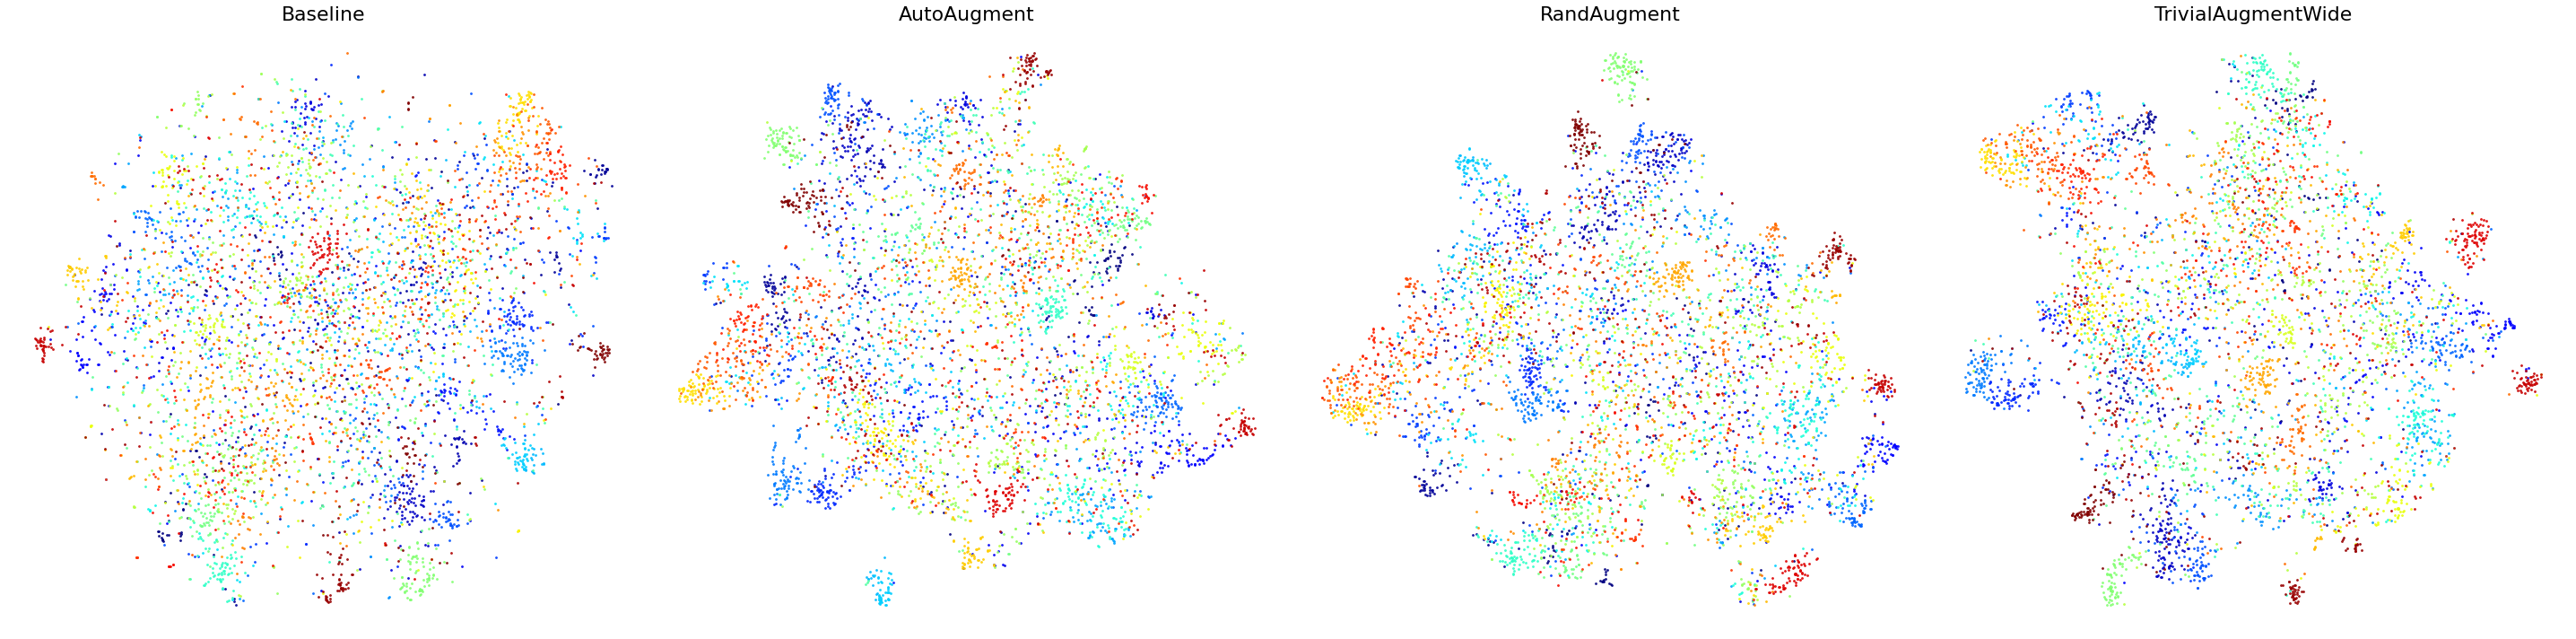

In [8]:
import matplotlib.pyplot as plt
from modules.plotting import plot_results

plot_results(results,"augmentation_methods")
plt.show()